In [9]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy import text
import os
import geopandas as gpd

In [10]:
host = 'localhost'
database = 'spatialdata'
user = 'postgres'
port = '5432'
password = os.getenv('SQL_PASSWORD')

In [11]:
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

engine = create_engine(connection_string)
insp = inspect(engine)
insp.get_table_names()

['spatial_ref_sys', 'nyc_census_blocks_2000', 'nyc_subway_stations']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_47700\95899795.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


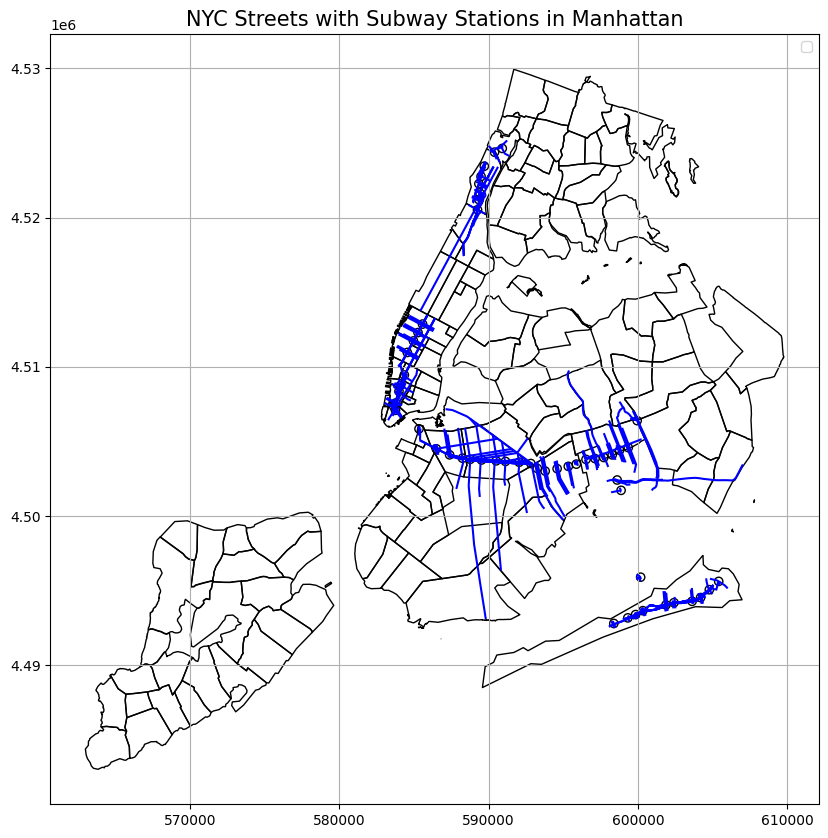

In [12]:
function_sql = """
CREATE OR REPLACE FUNCTION dynamic_subway_filter(
    schema_name TEXT,   -- Schema name
    table_name TEXT,    -- Table name

	schema_name02 TEXT,
	table_name02 TEXT, 
	
    column_name TEXT, -- Column name to filter
    subway_color TEXT, -- Value to filter by
	buffer_size NUMERIC
)
RETURNS TABLE (
    id double precision,
    name character varying(200),
	geom geometry(Point,26918))
	
AS 
$$
DECLARE
    sql_query TEXT;  -- Stores the dynamic SQL query
BEGIN
    -- Construct the dynamic SQL statement
    sql_query := format(
        'SELECT street.id, street.name, street.geom
        FROM %I.%I AS street
        JOIN %I.%I AS subway
        ON ST_Intersects(street.geom, ST_Buffer(subway.geom, %L))
        WHERE subway.%I = %L', 
        schema_name, table_name,schema_name02,table_name02,buffer_size, column_name, subway_color
    );

    -- Execute the dynamic query and return results
    RETURN QUERY EXECUTE sql_query;
END;
$$
LANGUAGE plpgsql;
"""

with engine.connect() as conn:
    conn.execute(text(function_sql))
    conn.commit()

sql_text = """select * from dynamic_subway_filter('ch05','streets', 'ch05', 'subway', 'color', 'BLUE', 100)"""

outcome_street = gpd.read_postgis(sql_text, con=engine)

## get neighborhoods
nbh_text = text(""" SELECT * FROM ch05.neighborhoods""")
all_nbh = gpd.read_postgis(nbh_text, con = engine)

## get outcome subway
subway_text = text(""" SELECT geom 
                      FROM ch05.subway
                      where color = 'BLUE' """)
outcome_subway = gpd.read_postgis(subway_text, con = engine)


fig, ax = plt.subplots(figsize=(12, 10))

all_nbh.plot(ax=ax,facecolor = 'none',)
outcome_subway.plot(ax=ax, facecolor = 'none',edgecolor='black')
outcome_street.plot(ax=ax, color = 'BLUE',edgecolor='black')


plt.title('NYC Streets with Subway Stations in Manhattan', fontsize=15)
plt.legend()
plt.grid(True)